In [1]:
import numpy as np
from numpy import cos,sin,pi
from numpy.random import random,randint,choice,sample
from matplotlib import pyplot as plt
import pandas as pd
import glob,cv2,time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers,Model

In [2]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(image: types.TensorLike, displacement: types.TensorLike, name: Optional[str] = None) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        displacement = tf.convert_to_tensor(displacement)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), displacement.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid + displacement
        query_points_flattened = tf.reshape(query_points_on_grid, [batch_size, height * width, 2])
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [3]:
def img_grad(imgs):
    #central different
    img_x,img_y = tf.image.image_gradients(imgs)
    img_x,img_y = (img_x+tf.roll(img_x,1,1))/2, (img_y+tf.roll(img_y,1,2))/2
    return img_x,img_y
def count_fold_fn(u):
    u = tf.convert_to_tensor(u)
    u_x,u_y = img_grad(u)
    det_u = (u_x[:,:,:,0]+1)*(u_y[:,:,:,1]+1)-u_x[:,:,:,1]*u_y[:,:,:,0]
    return tf.math.count_nonzero(det_u<=0).numpy()
def grid_warp(u,n=64):
    img_shape = u.shape[:-1]
    img = np.zeros(img_shape)
    for i in range(1,n):
        img[img_shape[0]*i//n,:]=1
        img[:,img_shape[0]*i//n]=1
    ex_img = np.expand_dims(np.expand_dims(img,-1),0)
    ex_u = np.expand_dims(u,0)
    warp = tf.squeeze(dense_image_warp(ex_img,ex_u))
    plt.imshow(warp,cmap='gray')
def vector_field(u,n=4):
    J,I = np.meshgrid(np.arange(256),np.arange(256))
    plt.gca().invert_yaxis()
    plt.quiver(J[::n,::n],I[::n,::n],u[::n,::n,1],-u[::n,::n,0],units='xy')

# Create dataset

## Generate images

In [4]:
def obj_on_img(img,obj_shape,color=1):
    m,n = img.shape
    if obj_shape=='rectangle':
        start_point = randint(m/4,m/2),randint(n/4,n/2)
        end_point = randint(m/8,m/4)+start_point[0],randint(n/8,n/4)+start_point[1]
        cv2.rectangle(img,start_point,end_point,color,-1)
    if obj_shape=='circle':
        center_point = randint(3*m/8,5*m/8),randint(3*n/8,5*n/8)
        min_shape = min(m,n)
        radius = randint(min_shape/8,min_shape/6)
        cv2.circle(img,center_point,radius,color,-1)
    if obj_shape=='ellipse':
        center_point = randint(3*m/8,5*m/8),randint(3*n/8,5*n/8)
        axes = randint(m/8,m/6),randint(n/8,n/6)
        angle = randint(360)
        start_angle = randint(180)
        end_angle = max(randint(360),90)+start_angle
        cv2.ellipse(img,center_point,axes,angle,start_angle,end_angle,color,-1)
    return img

## Generate displacement fields

In [5]:
def rotate_n_shear(shape):
    m,n = shape
    C,R = np.meshgrid(np.arange(n)-(n-1)/2,np.arange(m)-(m-1)/2)
    theta = 2*pi*random()
    sx,sy = random(2)-0.5
    rotate = np.array([[cos(-theta),-sin(-theta)],
                       [sin(-theta),cos(-theta)]])
    shear = np.array([[1,sx],
                      [sy,1]])
    A = rotate.dot(shear)
    I = A[0,0]*R+A[0,1]*C-R
    J = A[1,0]*R+A[1,1]*C-C
    u = np.stack([I,J],axis=-1)
    return u

def local_deform(shape):
    m,n = shape
    J,I = np.meshgrid(np.arange(n)-(n-1)/2,np.arange(m)-(m-1)/2)
    theta = np.arctan(J/I)
    r1 = random()/5
    r2 = 7*random()+3
    r3 = min(m,n)*random()/8
    u1 = r1*np.cos(r2*theta+r3)*I
    u2 = r1*np.cos(r2*theta+r3)*J
    u = np.stack([u1,u2],axis=-1)
    return u

## Generate dataset

In [6]:
# start_time = time.time()
# number = 500
# number_object = 3
# img_shape = (256,256)
# for i in range(number):
#     #moved image dataset
#     img = np.zeros(img_shape)
#     for j in range(number_object):
#         shape_list = ['rectangle','circle','ellipse']
#         img = obj_on_img(img,choice(shape_list),color=random())
#         rns = rotate_n_shear(img_shape)
#         ex_img = np.expand_dims(np.expand_dims(img,-1),0)
#         ex_rns = np.expand_dims(rns,0)
#         rns_img = dense_image_warp(ex_img,ex_rns)
#         img = tf.squeeze(rns_img).numpy()
#     moved_imgs = np.concatenate([moved_imgs,rns_img]) if i>0 else rns_img
    
#     #displacement field dataset
#     u = local_deform(img_shape)
#     ex_u = np.expand_dims(u,0)
#     disp_fields = np.concatenate([disp_fields,ex_u]) if i>0 else ex_u
    
#     #fixed image dateset
#     warp_img = dense_image_warp(rns_img,ex_u)
#     fixed_imgs = np.concatenate([fixed_imgs,warp_img]) if i>0 else warp_img
# print(time.time()-start_time)

## Example of local deformation from dataset

In [7]:
# num_samples = 3
# for i in choice(moved_imgs.shape[0],num_samples,False):
#     img = moved_imgs[i]
#     u = disp_fields[i]
#     print('number of folding =',count_fold_fn(tf.expand_dims(u,axis=0)))
#     ex_img = np.expand_dims(img,0)
#     ex_u = np.expand_dims(u,0)
#     warp_img = dense_image_warp(ex_img,ex_u)
#     plt.figure(figsize=(16,4))
#     plt.subplot(141)
#     plt.imshow(img,cmap='gray')
#     plt.subplot(142)
#     plt.imshow(tf.squeeze(warp_img),cmap='gray')
#     plt.subplot(143)
#     grid_warp(u)
#     plt.subplot(144)
#     vector_field(-u)
#     plt.show()

# Train/Test spliting

In [8]:
# N = moved_imgs.shape[0]
# train_ratio = 0.98
# train_size = int(train_ratio*N)
# train_set = np.concatenate([moved_imgs[:train_size],fixed_imgs[:train_size]],axis=-1)
# test_set = np.concatenate([moved_imgs[train_size:],fixed_imgs[train_size:]],axis=-1)

In [9]:
#load dataset
train_set = np.load('trainset.npy')
test_set = np.load('testset.npy')
train_size = train_set.shape[0]
img_shape = train_set.shape[1:3]

# Loss definition

In [10]:
def D_MSE(img1,img2):
    mse = tf.reduce_mean(tf.square(img1-img2),axis=[1,2,3])
    return tf.cast(tf.reduce_mean(mse),tf.float32)

def D_CC(img1,img2,n=9):
    gs_img1 = tfa.image.gaussian_filter2d(img1,filter_shape=(n,n))
    gs_img2 = tfa.image.gaussian_filter2d(img2,filter_shape=(n,n))
    dif_img1 = img1-gs_img1
    dif_img2 = img2-gs_img2
    cc = tf.reduce_sum(dif_img1*dif_img2,axis=[1,2,3])**2
    cc = cc/(tf.reduce_sum(dif_img1**2,axis=[1,2,3])*tf.reduce_sum(dif_img2**2,axis=[1,2,3]))
    return tf.reduce_mean(cc)

def D_NGF(img1,img2,e=1e-3):
    img1_x,img1_y = img_grad(img1)
    img2_x,img2_y = img_grad(img2)
    inner = lambda a,b: a*b+e**2
    norm_s = lambda a,b: inner(a,a)+inner(b,b)
    ngf = 1 - ((inner(img1_x,img2_x)+inner(img1_y,img2_y))**2)/(norm_s(img1_x,img1_y)*norm_s(img2_x,img2_y))
    return tf.reduce_mean(tf.reduce_sum(ngf,axis=[1,2,3]))

def D_CLM(img1,img2):
    img1 = tf.convert_to_tensor(img1)
    img2 = tf.convert_to_tensor(img2)
    b,h,w,c = img1.get_shape()
    tile_fn = lambda b_c: tf.transpose(tf.reshape(tf.tile(b_c,(h,w)),[h,b,w,c]),[1,0,2,3])
    img1_mean = tile_fn(tf.math.reduce_mean(img1,axis=[1,2]))
    img2_mean = tile_fn(tf.math.reduce_mean(img2,axis=[1,2]))
    img1_std = tile_fn(tf.math.reduce_std(img1,axis=[1,2]))
    img2_std = tile_fn(tf.math.reduce_std(img2,axis=[1,2]))
    img12_std = tile_fn(tf.math.reduce_std(img1+img2,axis=[1,2]))
    clm = tf.reduce_sum(((img1-img1_mean)/img1_std-(img2-img2_mean)/img2_std)**2,axis=(1,2,3))+(img1_std+img2_std-img12_std)**2
    return tf.cast(tf.reduce_mean(clm),tf.float32)
    
def R_difsn(u):
    u_x,u_y = img_grad(u)
    difsn = tf.reduce_sum(u_x**2+u_y**2,axis=[1,2,3])
    return tf.reduce_mean(difsn)

def R_curv(u):
    u_x,u_y = tf.image.image_gradients(u) #forward different
    u_xx = u_x-tf.roll(u_x,1,1)
    u_yy = u_y-tf.roll(u_y,1,2)
    curv = tf.reduce_sum(u_xx**2+u_yy**2,axis=[1,2,3])
    return tf.reduce_mean(curv)

def R_fold(u):
    u = tf.convert_to_tensor(u)
    u_x,u_y = img_grad(u)
    det_phi = (u_x[:,:,:,0]+1)*(u_y[:,:,:,1]+1)-u_x[:,:,:,1]*u_y[:,:,:,0]
    fold = tf.reduce_sum((det_phi-1)**4/det_phi**2,axis=(1,2))
    return tf.reduce_mean(fold)

# Model

In [11]:
tf.keras.backend.clear_session()
inputs = layers.Input(shape=train_set[0].shape)
Conv2D = lambda l: layers.Conv2D(l,3,activation='relu',padding='same')
Maxpool2D = layers.MaxPool2D()
UpSampling2D = layers.UpSampling2D()
Concatenate = layers.Concatenate()

x = Conv2D(32)(inputs)
skip = []
for _ in range(4):
    skip.append(x)
    x = Maxpool2D(x)
    x = Conv2D(64)(x)
for _ in range(4):
    x = UpSampling2D(x)
    x = Concatenate([x,skip.pop()])
    x = Conv2D(64)(x)
x = Conv2D(32)(x)
x = Conv2D(32)(x)
x = tf.keras.layers.Conv2D(2,3,padding='same')(x)
model = Model(inputs=inputs, outputs=x,name='Unet')
model.summary()
weight_save = model.get_weights()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    multiple             0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
                                                                 conv2d_3[0][0]                

In [12]:
def loss_fn(model,imgs,cont=[1e6],t=None):
    u = model(imgs)
    ref_img = imgs[:,:,:,1:]
    warped_img = dense_image_warp(imgs[:,:,:,:1],u)
    loss = cont[0]*D_MSE(ref_img,warped_img)+R_curv(u)+R_difsn(u)
    return loss

def grad_fn(model,imgs,t=None):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model,imgs,t=t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [13]:
model.set_weights(weight_save)
epochs = 100
batch_size = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_log = []
metric_log = []
start_train = time.time()
for epoch in range(epochs):
    loss_epoch = []
    metric_epoch = []
    for i in range(0,train_size,batch_size):
        train_batch = train_set[i:i+batch_size]
        loss_batch, grads = grad_fn(model,train_batch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        loss_epoch.append(loss_batch.numpy())
    loss_test = loss_fn(model,test_set)
    loss_log = np.append(loss_log,[np.mean(loss_epoch),loss_test])
    dgt = 5 #display 'dgt' digits
    print('epoch {}, loss_train {}, loss_test {}'.format(epoch+1,np.round(loss_log[-2],dgt),np.round(loss_log[-1],dgt)))
loss_log = loss_log.reshape(epochs,2)
print(time.time()-start_train)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
epoch 1, loss_train 2247.41992, loss_test 1261.63574
epoch 2, loss_train 1337.6687, loss_test 1182.18152
epoch 3, loss_train 1203.61499, loss_test 1081.74329
epoch 4, loss_train 1094.69348, loss_test 1006.0506
epoch 5, loss_train 1048.10901, loss_test 959.51917
epoch 6, loss_train 989.15619, loss_test 905.61414
epoch 7, loss_train 997.11322, loss_test 953.71423
epoch 8, loss_train 940.00787, loss_test 859.7403
epoch 9, loss_train 954.50415, loss_test 944.04718
epoch 10, loss_train 959.49695, loss_test 877.41003
epoch 11, loss_train 960.57129, loss_test 852.95526
epoch 12, loss_train 934.0769, loss_test 841.8999
epoch 13, loss_train 911.09692, loss_test 837.92822
epoch 14, loss_train 881.20752, loss_test 815.42712
epoch 15, loss_train 876.05493, loss_test 818.51343
epoch 16, loss_train 843.98004, loss_test 808.10016
epoch 17, loss_train 865.26764, los

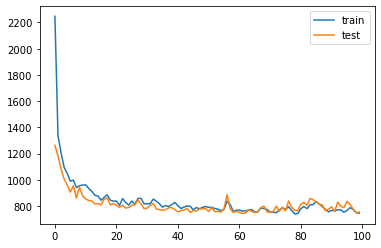

In [14]:
plt.plot(loss_log[:,0],label='train')
plt.plot(loss_log[:,1],label='test')
plt.legend()
plt.show()

relative ssd =  0.061948058124870614
number of folding = 0


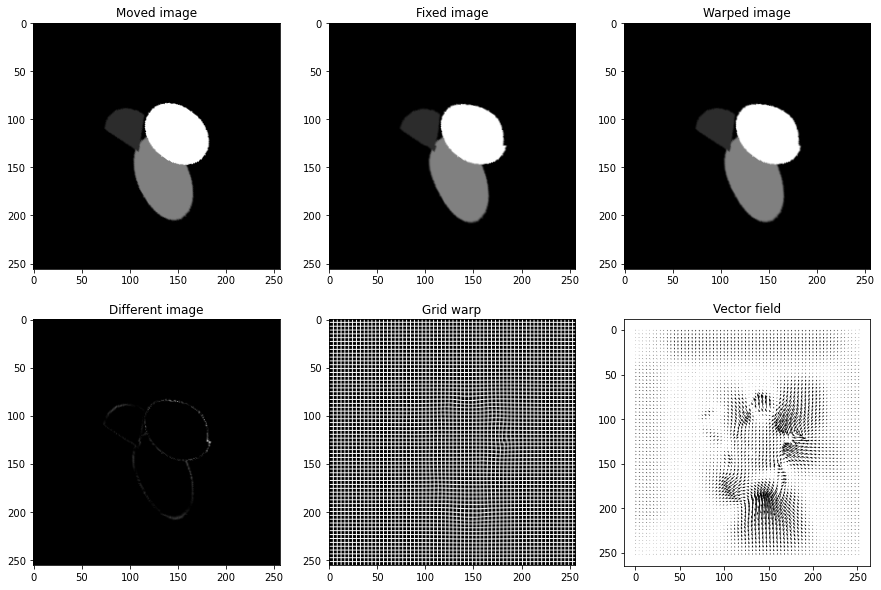

relative ssd =  0.05602915930455967
number of folding = 0


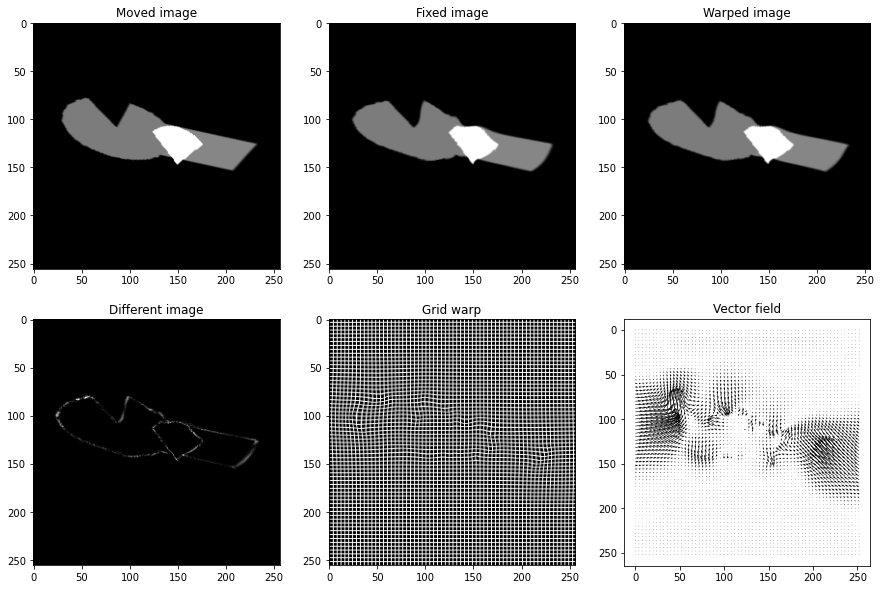

relative ssd =  0.0802846702864642
number of folding = 0


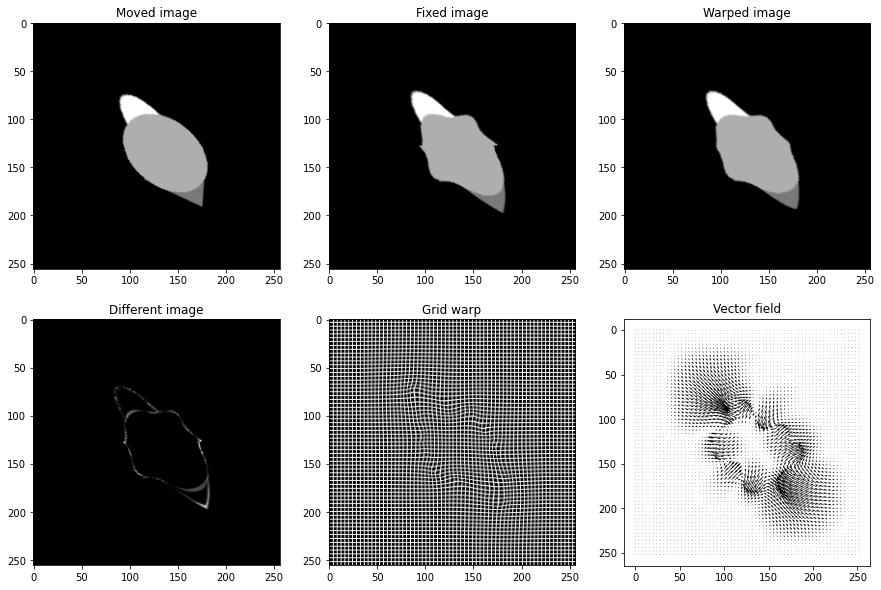

In [15]:
ind_list = choice(test_set.shape[0],3,False)
for ind in ind_list:
    test = np.expand_dims(test_set[ind],0)
    moved_img = test[0,:,:,0]
    fixed_img = test[0,:,:,1]
    u = model(test)
    #u_gt = disp_fields[train_size+ind]
    warped_img = tf.squeeze(dense_image_warp(test[:,:,:,:1],u))
    #warped_gt = tf.squeeze(dense_image_warp(test[:,:,:,:1],u_gt))
    print('relative ssd = ',np.sum((warped_img-fixed_img)**2)/np.sum((moved_img-fixed_img)**2))
    print('number of folding =',count_fold_fn(u))
    plt.figure(figsize=(15,10))
    plt.subplot(231)
    plt.title('Moved image')
    plt.imshow(moved_img,cmap='gray')
    plt.subplot(232)
    plt.title('Fixed image')
    plt.imshow(fixed_img,cmap='gray')
    plt.subplot(233)
    plt.title('Warped image')
    plt.imshow(warped_img,cmap='gray')
    plt.subplot(234)
    plt.title('Different image')
    plt.imshow(abs(warped_img-fixed_img),cmap='gray')
    plt.subplot(235)
    plt.title('Grid warp')
    grid_warp(u[0],n=64)
    plt.subplot(236)
    plt.title('Vector field')
    vector_field(u[0],n=4)
    plt.show()

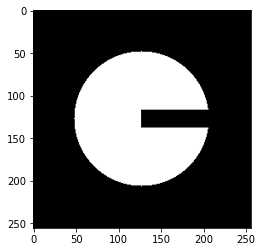

In [16]:
c_shape = cv2.circle(np.zeros(img_shape),(255//2,255//2),79,1,-1)
c_shape = cv2.circle(c_shape,(255//2,255//2),40,0,-1)
c_shape = cv2.rectangle(c_shape,(127,107),(250,147),0,-1)
plt.imshow(c_shape,cmap='gray')

o_ = cv2.circle(np.zeros(img_shape),(255//2,255//2),79,1,-1)
o_ = cv2.rectangle(o_,(127,117),(250,137),0,-1)
plt.imshow(o_,cmap='gray')

number of folding = 118
relative ssd =  0.12359570135497952


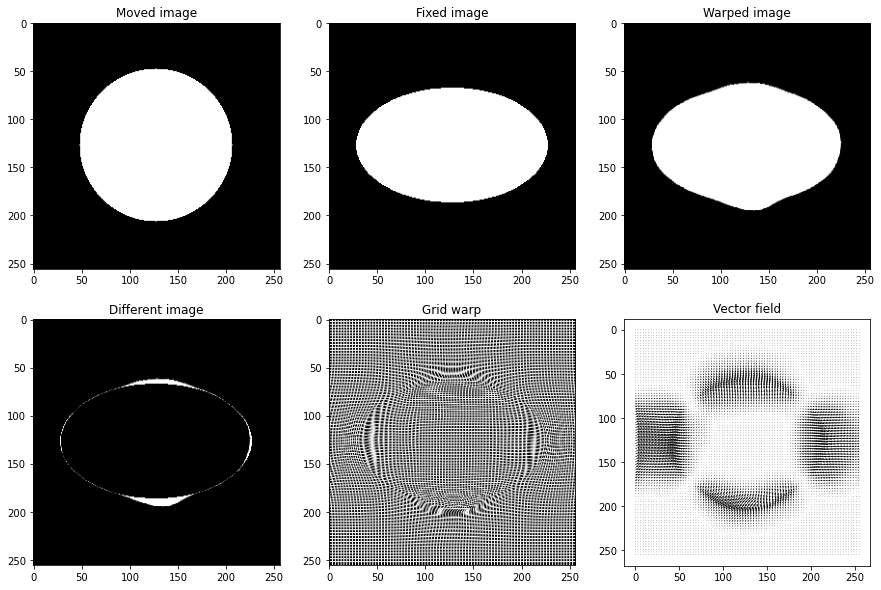

In [17]:
moved_img = cv2.circle(np.zeros(img_shape),(255//2,255//2),79,1,-1)
fixed_img = cv2.ellipse(np.zeros(img_shape),(255//2,255//2),(99,59),0,0,360,1,-1)
stack = np.expand_dims(np.stack([moved_img,fixed_img],-1),0)
u = model(stack)
#u_gt = disp_fields[train_size+ind]
warped_img = tf.squeeze(dense_image_warp(np.expand_dims(np.expand_dims(moved_img,-1),0),u))
#warped_gt = tf.squeeze(dense_image_warp(test[:,:,:,:1],u_gt))
print('number of folding =',count_fold_fn(u))
print('relative ssd = ',np.sum((warped_img-fixed_img)**2)/np.sum((moved_img-fixed_img)**2))
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.title('Moved image')
plt.imshow(moved_img,cmap='gray')
plt.subplot(232)
plt.title('Fixed image')
plt.imshow(fixed_img,cmap='gray')
plt.subplot(233)
plt.title('Warped image')
plt.imshow(warped_img,cmap='gray')
plt.subplot(234)
plt.title('Different image')
plt.imshow(abs(warped_img-fixed_img),cmap='gray')
plt.subplot(235)
plt.title('Grid warp')
grid_warp(u[0],n=85)
plt.subplot(236)
plt.title('Vector field')
vector_field(u[0],n=3)
plt.show()

In [18]:
model.save_weights('diff_curv_reg')